[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sensioai/blog/blob/master/050_cv_segmentacion/cv_segmentacion.ipynb)

# Segmentación

Seguimos explorando diferentes aplicaciones de visión artificial. En posts anteriores hemos hablado de [localización](https://sensioai.com/blog/047_cv_loc_clas) y [detección de objetos](https://sensioai.com/blog/048_cv_detection). En este caso exploraremos la tarea de segmentación semántica, consistente en clasificar todos y cada uno de los píxeles en una imagen.

![](https://miro.medium.com/max/1575/1*kvh9u8W2sHlQoBPfwERggA.gif)

Si bien en la tarea de clasificación consiste en asignar una etiqueta a una imagen en particular, en la tarea de segmentación tendremos que asignar una etiqueta a cada pixel produciendo `mapas de segmentación`, imágenes con la misma resolución que la imagen utilizada a la entrada de nuestro modelo en la que cada pixel es sustituido por una etiqueta.

En las arquitecturas que hemos utilizado en el resto de tareas, las diferentes capas convolucionales van reduciendo el tamaño de los mapas de características (ya sea por la configuración de filtros utilizados o el uso de `pooling`). Para hacer clasificación conectamos la salida de la última capa convolucional a un `MLP` para generar las predicciones, mientras que para la detección utilizamos diferentes capas convolucionales a diferentes escalas para generar las cajas y clasificación. En el caso de la segmentación necesitamos de alguna manera recuperar las dimensiones originales de la imagen. Vamos a ver algunos ejemplos de arquitecturas que consiguen esto mismo.

## Arquitecturas

La primera idea que podemos probar es utilizar una `CNN` que no reduzca las dimensiones de los diferentes mapas de características, utilizando la correcta configuración de filtros y sin usar `pooling`.

![](https://theaisummer.com/assets/img/posts/Semantic_Segmentation/fcn1.jpg)

Este tipo de arquitectura, sin embargo, no será capaz de extraer características a diferentes escalas y además será computacionalmente muy costos. Podemos aliviar estos problemas utilizando una arquitectura `encoder-decoder`, en la que en una primera etapa una `CNN` extrae características a diferentes escalas y luego otra `CNN` recupera las dimensiones originales.

![](https://codealogic.files.wordpress.com/2018/05/ml2.png?w=810)

Para poder utilizar este tipo de arquitecturas necesitamos alguna forma de incrementar la dimensión de un mapa de características. De entre las diferentes opciones, una muy utilizada es el uso de `convoluciones traspuestas`, una capa muy parecida a la capa convolucional que "aprende" la mejor forma de aumentar un mapa de características aplicando filtros que aumentan la resolución.

![](https://miro.medium.com/max/1972/1*kOThnLR8Fge_AJcHrkR3dg.gif)

In [ ]:
#import torch

#input = torch.randn(64, 10, 20, 20)
# aumentamos la dimensión x2
#conv_trans = torch.nn.ConvTranspose2d(
#    in_channels=10,
#    out_channels=10,
#    kernel_size=2,
#    stride=2)
#output = conv_trans(input)
#output.shape

Puedes aprender más sobre esta operación en la [documentación](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) de `Pytorch`. De esta manera podemos diseñar arquitecturas más eficientes capaces de extraer información relevante a varias escalas. Sin embargo, puede ser un poco complicado recuperar información en el `decoder` simplemente a partir de la salida del `encoder`. Para resolver este problema se desarrolló una de las arquitecturas más conocidas y utilizadas para la segmentación: la red `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

Esta arquitectura es muy similar a la anterior, con la diferencia de que en cada etapa del `decoder` no solo entra la salida de la capa anterior sino también la salida de la capa correspondiente del `encoder`. De esta manera la red es capaz de aprovechar mucho mejor la información a las diferentes escalas.

Vamos a ver cómo implementar esta arquitectura para hacer segmentación de MRIs.

## El Dataset

Podemos descargar un conjunto de imágenes de MRIs con sus correspondientes máscaras de segmentación usando el siguiente enlace.

Nuestro objetivo será el de segmentar una MRI cerebral para detectar la materia gris y blanca. Determinar la cantidad de ambas así como su evolución en el tiempo para un mismo paciente es clave para la detección temprana y tratamiento de enfermedades como el alzheimer.

In [ ]:
#!pip install roboflow

#from roboflow import Roboflow
#rf = Roboflow(api_key="s83H6iFqtVcuowwX5DOr")
#project = rf.workspace("luis-gustavo-ortiz-8i22r").project("segmentacion-8r6bg")
#dataset = project.version(6).download("coco-segmentation")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pycocotools.coco import COCO
from PIL import Image, ImageOps
!ls

drive  sample_data


In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
import torch
import torchvision
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
coco_data=COCO("/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/_annotations.coco.json")
#coco_data2=COCO("/content/drive/MyDrive/2-SIS421/2parcial/dataset/SEGMENTACION.v3i.coco-segmentation/train/_annotations.coco.json")

loading annotations into memory...
Done (t=0.39s)
creating index...
index created!


In [ ]:
img = coco_data.imgs[3]
print(len(coco_data.imgs))
img

975


{'id': 3,
 'license': 1,
 'file_name': 'platillos_107_jpg.rf.009e17c475dc43bb33f06fb39d83fbbd.jpg',
 'height': 394,
 'width': 394,
 'date_captured': '2023-11-09T02:31:40+00:00'}

uint8


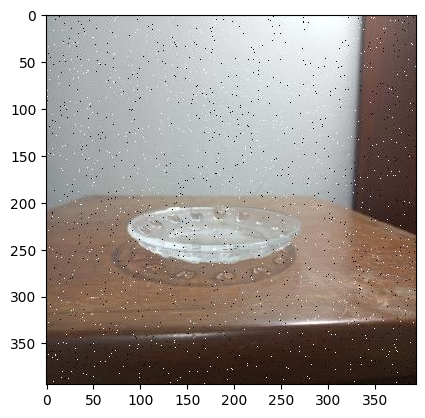

In [ ]:
imagen = np.array(Image.open("/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/"+img['file_name']))
print(imagen.dtype)
plt.imshow(imagen, interpolation='nearest')
plt.show()

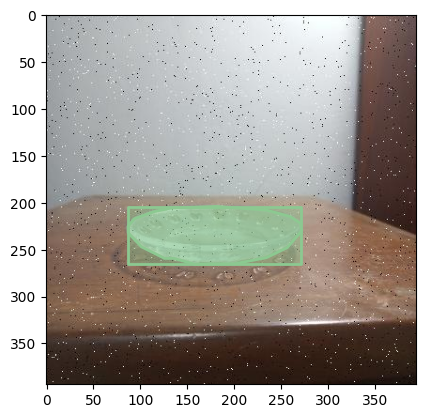

In [ ]:
plt.imshow(imagen)
cat_ids = coco_data.getCatIds()
#print(cat_ids)
anns_ids = coco_data.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
#print(anns_ids)
anns = coco_data.loadAnns(anns_ids)
#print(anns)
coco_data.showAnns(anns,draw_bbox=True)

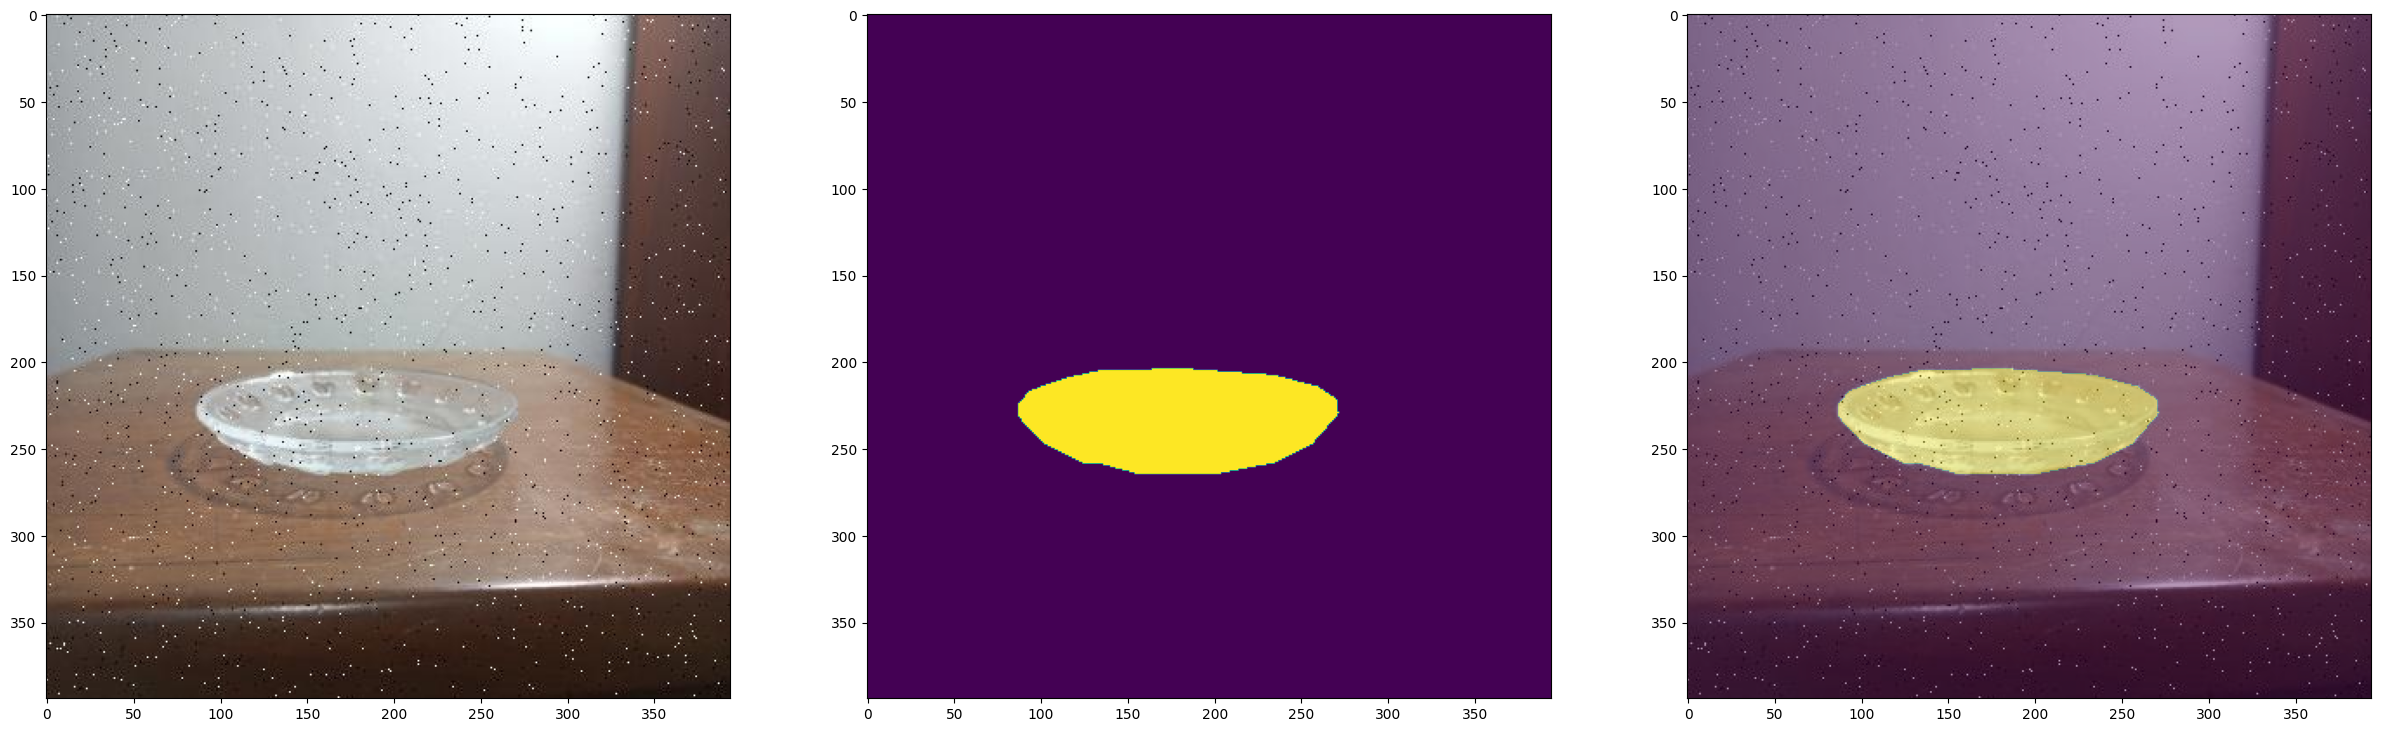

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

mask = coco_data.annToMask(anns[0])
#print(mask.shape)
for i in range(len(anns)):
    mask += coco_data.annToMask(anns[i])
    #print(mask)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [ ]:
#Normalizar la imagen
imag = np.array(imagen)/255
image = imag.astype(np.float32)

Nuestras imágenes tienen 394 x 394 píxeles, almacenadas como `arrays` de `NumPy` (que podemos cargar con la función `np.load`). Ya están normalizadas y en formato `float32`.

In [ ]:
image.shape, image.dtype, image.max(), image.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

En cuanto a las máscaras, también las tenemos guardadas como `arrays` de `NumPy`. En este caso el tipo es `unit8`, y la resolución es la misma que las de la imagen original. En cada píxel podemos encontrar tres posibles valores: 0, 1 ó 2. Este valor indica la clase (0 corresponde con materia blanca, 1 con materia gris, 2 con *background*).

In [ ]:
mask.shape, mask.dtype, mask.max(), mask.min()

((394, 394), dtype('uint8'), 2, 0)

A la hora de entrenar nuestra red necesitaremos esta máscara en formato `one-hot encoding`, en el que extenderemos cada pixel en una lista de longitud igual al número de clases (en este caso 3) con valores de 0 en todas las posiciones excepto en aquella que corresponda con la clase, dónde pondremos un 1.

In [ ]:
mask_oh = (np.arange(3) == mask[...,None]).astype(np.float32)

mask_oh.shape, mask_oh.dtype, mask_oh.max(), mask_oh.min()

((394, 394, 3), dtype('float32'), 1.0, 0.0)

## UNet

Vamos ahora a implementar nuestra red neuronal similar a `UNet`.

![](https://www.researchgate.net/profile/Alan_Jackson9/publication/323597886/figure/fig2/AS:601386504957959@1520393124691/Convolutional-neural-network-CNN-architecture-based-on-UNET-Ronneberger-et-al.png)

In [ ]:
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((1,3,394,394)))
output.shape

torch.Size([1, 3, 394, 394])

## Fit de 1 muestra

Para comprobar que todo funciona vamos a hacer el fit de una sola muestra. Para optimizar la red usamos la función de pérdida `BCEWithLogitsLoss`, que aplicará la función de activación `sigmoid` a las salidas de la red (para que estén entre 0 y 1) y luego calcula la función `binary cross entropy`.

In [ ]:


device = "cuda" if torch.cuda.is_available() else "cpu"

def fit(model, X, y, epochs=1, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f}")

In [ ]:
img_tensor = torch.tensor(image).permute(2,0,1).unsqueeze(0)
mask_tensor = torch.tensor(mask_oh).permute(2, 0, 1).unsqueeze(0)

img_tensor.shape, mask_tensor.shape

(torch.Size([1, 3, 394, 394]), torch.Size([1, 3, 394, 394]))

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=30)

Epoch 1/30 loss 0.70710
Epoch 2/30 loss 0.68722
Epoch 3/30 loss 0.67301
Epoch 4/30 loss 0.65997
Epoch 5/30 loss 0.64751
Epoch 6/30 loss 0.63566
Epoch 7/30 loss 0.62406
Epoch 8/30 loss 0.61234
Epoch 9/30 loss 0.60061
Epoch 10/30 loss 0.58931
Epoch 11/30 loss 0.57866
Epoch 12/30 loss 0.56857
Epoch 13/30 loss 0.55890
Epoch 14/30 loss 0.54954
Epoch 15/30 loss 0.54049
Epoch 16/30 loss 0.53180
Epoch 17/30 loss 0.52340
Epoch 18/30 loss 0.51520
Epoch 19/30 loss 0.50714
Epoch 20/30 loss 0.49918
Epoch 21/30 loss 0.49132
Epoch 22/30 loss 0.48353
Epoch 23/30 loss 0.47577
Epoch 24/30 loss 0.46805
Epoch 25/30 loss 0.46044
Epoch 26/30 loss 0.45292
Epoch 27/30 loss 0.44543
Epoch 28/30 loss 0.43792
Epoch 29/30 loss 0.43045
Epoch 30/30 loss 0.42304


La función de pérdida va bajando, por lo que parece que está funcionando bien. Sin embargo, necesitamos alguna métrica para evaluar cuánto se parecen las máscaras predichas a las reales. Para ello podemos usar la métrica `IoU`, de la que ya hablamos anteriormente, y que calcula la relación entre la intersección y la unión de dos áreas.

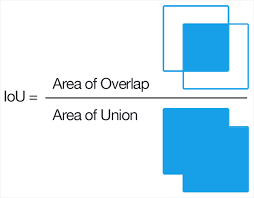

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
def fit(model, X, y, epochs=1, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    X, y = X.to(device), y.to(device)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.5f}")

In [ ]:
fit(model, img_tensor, mask_tensor, epochs=100)

Epoch 1/100 loss 0.62029 iou 0.44729
Epoch 2/100 loss 0.58579 iou 0.46315
Epoch 3/100 loss 0.55505 iou 0.46882
Epoch 4/100 loss 0.52595 iou 0.47093
Epoch 5/100 loss 0.49868 iou 0.47132
Epoch 6/100 loss 0.47349 iou 0.47140
Epoch 7/100 loss 0.44977 iou 0.47141
Epoch 8/100 loss 0.42734 iou 0.47141
Epoch 9/100 loss 0.40542 iou 0.47140
Epoch 10/100 loss 0.38371 iou 0.47141
Epoch 11/100 loss 0.36253 iou 0.47140
Epoch 12/100 loss 0.34310 iou 0.47143
Epoch 13/100 loss 0.32439 iou 0.47140
Epoch 14/100 loss 0.30607 iou 0.47142
Epoch 15/100 loss 0.28889 iou 0.47150
Epoch 16/100 loss 0.27264 iou 0.47175
Epoch 17/100 loss 0.25732 iou 0.47216
Epoch 18/100 loss 0.24305 iou 0.47190
Epoch 19/100 loss 0.22974 iou 0.47157
Epoch 20/100 loss 0.21794 iou 0.47148
Epoch 21/100 loss 0.20703 iou 0.47147
Epoch 22/100 loss 0.19685 iou 0.47146
Epoch 23/100 loss 0.18724 iou 0.47146
Epoch 24/100 loss 0.17839 iou 0.47145
Epoch 25/100 loss 0.17018 iou 0.47144
Epoch 26/100 loss 0.16264 iou 0.47143
Epoch 27/100 loss 0.1

Ahora podemos generar predicciones para obtener máscaras de segmentación

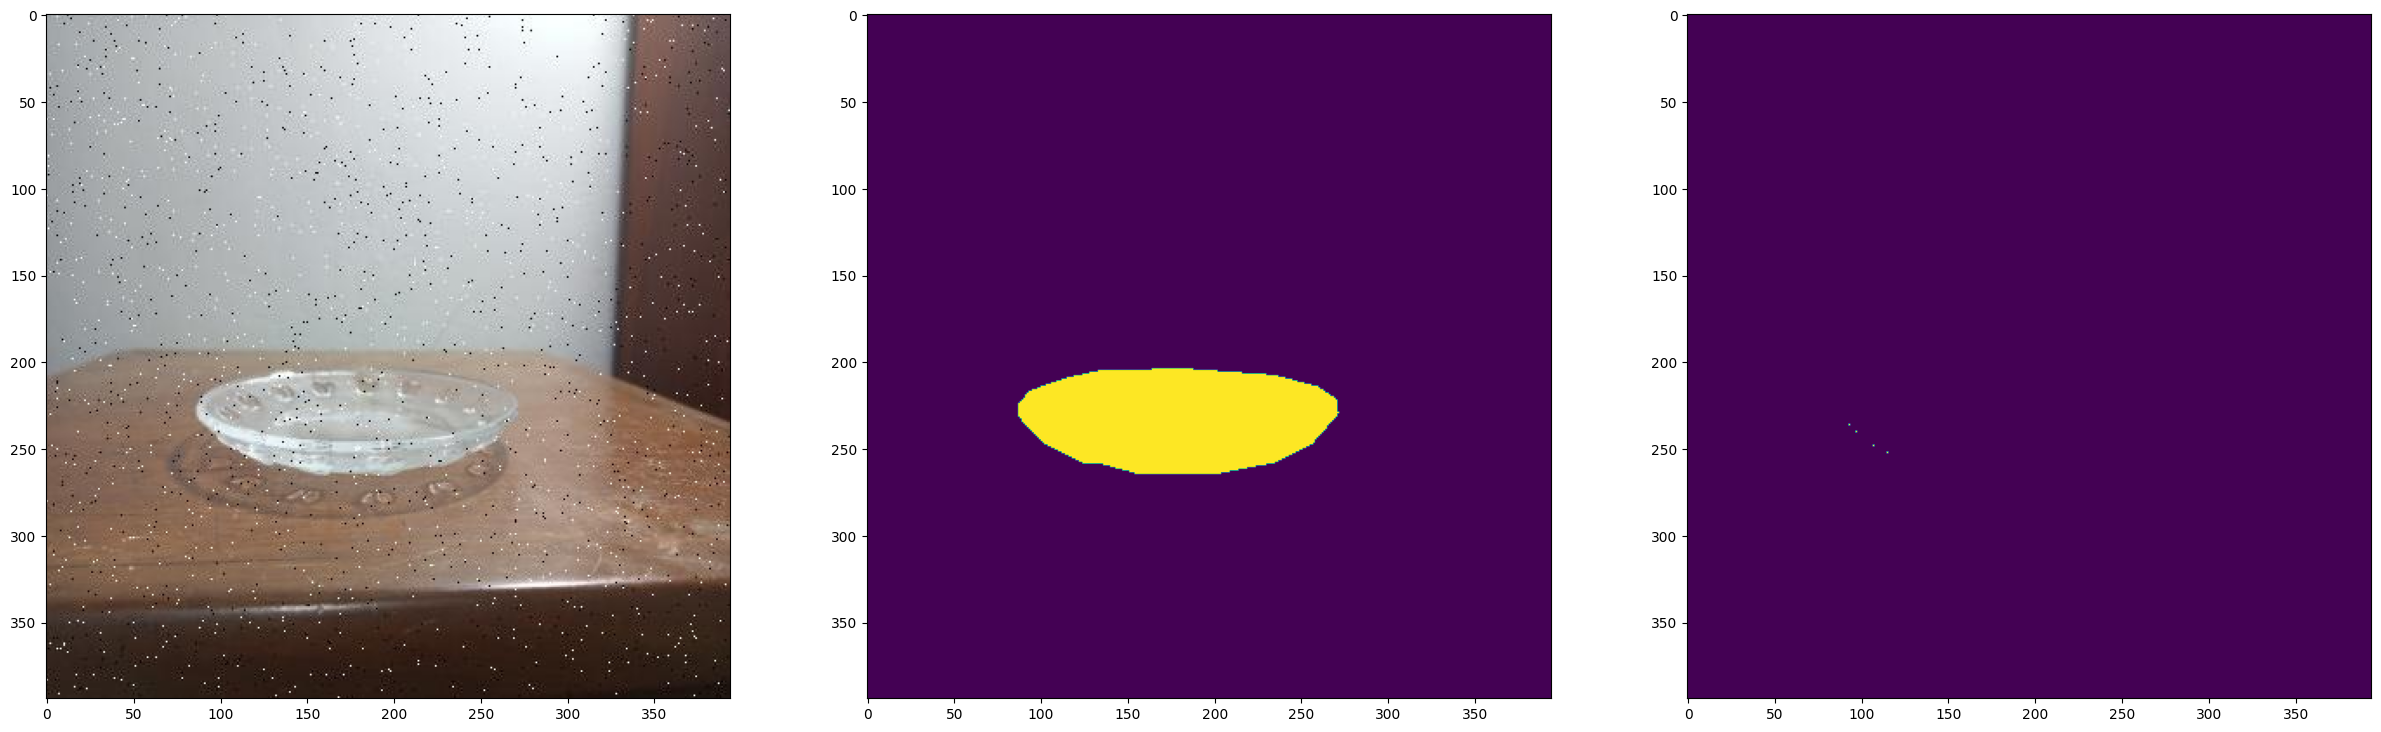

In [ ]:
model.eval()
with torch.no_grad():
    output = model(img_tensor.to(device))[0]
    pred_mask = torch.argmax(output, axis=0)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
ax1.imshow(image)
ax2.imshow(mask)
ax3.imshow(pred_mask.squeeze().cpu().numpy())
plt.show()

In [ ]:
from random import sample
import numpy as np
from PIL import Image

def loadImages(dataset_coco, split=0.2):
    img_test_ = []
    img_train_ = []
    mask_test_ = []
    mask_train_ = []
    labels_test_ = []
    labels_train_ = []
    data_ = dataset_coco.anns
    data = dataset_coco.imgs
    print(len(data))
    test_ids = sample(list(data.keys()), int(len(data) * split))
    #print("test",test_ids)
    for i in data:

        image_id_ = data[i]['id']
        #print("a",image_id_)
        category = data_[i]['category_id']
        #print("b",category)
        img_ = dataset_coco.imgs[i]
        #print("c",img_)
        image_path = "/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/" + img_['file_name']
        image_load_ = Image.open(image_path).convert('RGB')
        image_ = np.array(image_load_) / 255
        #print(image)
        cat_ids = coco_data.getCatIds()
        #print(cat_ids)
        anns_ids = coco_data.getAnnIds(imgIds=img_['id'], catIds=cat_ids, iscrowd=None)
        #print(anns_ids)
        anns_ = coco_data.loadAnns(anns_ids)
        #print("d",anns_, len(anns_))
        masks_ = []
        for ann in anns_:
            mask = dataset_coco.annToMask(ann)
            masks_.append(mask)
            #print("las masks",masks_)
        mask_ = np.sum(masks_, axis=0)
        #print(mask_)
        if i not in test_ids:
            img_train_.append(image_path)
            mask_train_.append(mask_)
            labels_train_.append(category)
        else:
            img_test_.append(image_path)
            mask_test_.append(mask_)
            labels_test_.append(category)
    return np.array(img_train_), np.array(img_test_), np.array(mask_train_), np.array(mask_test_), np.array(labels_train_), np.array(labels_test_)


In [ ]:
img_train, img_test, mask_train, mask_test, labels_train ,labels_test = loadImages(coco_data, split=0.2)

975


In [ ]:
img_train[3], img_test[0], mask_train[7].shape, mask_test[0].shape, labels_train[0] ,labels_test[0]

('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_107_jpg.rf.009e17c475dc43bb33f06fb39d83fbbd.jpg',
 '/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/train/platillos_49_jpg.rf.014ef52e81762262d87902a6b1aa6451.jpg',
 (394, 394),
 (394, 394),
 3,
 1)

uint8
(394, 394)
(394, 394)


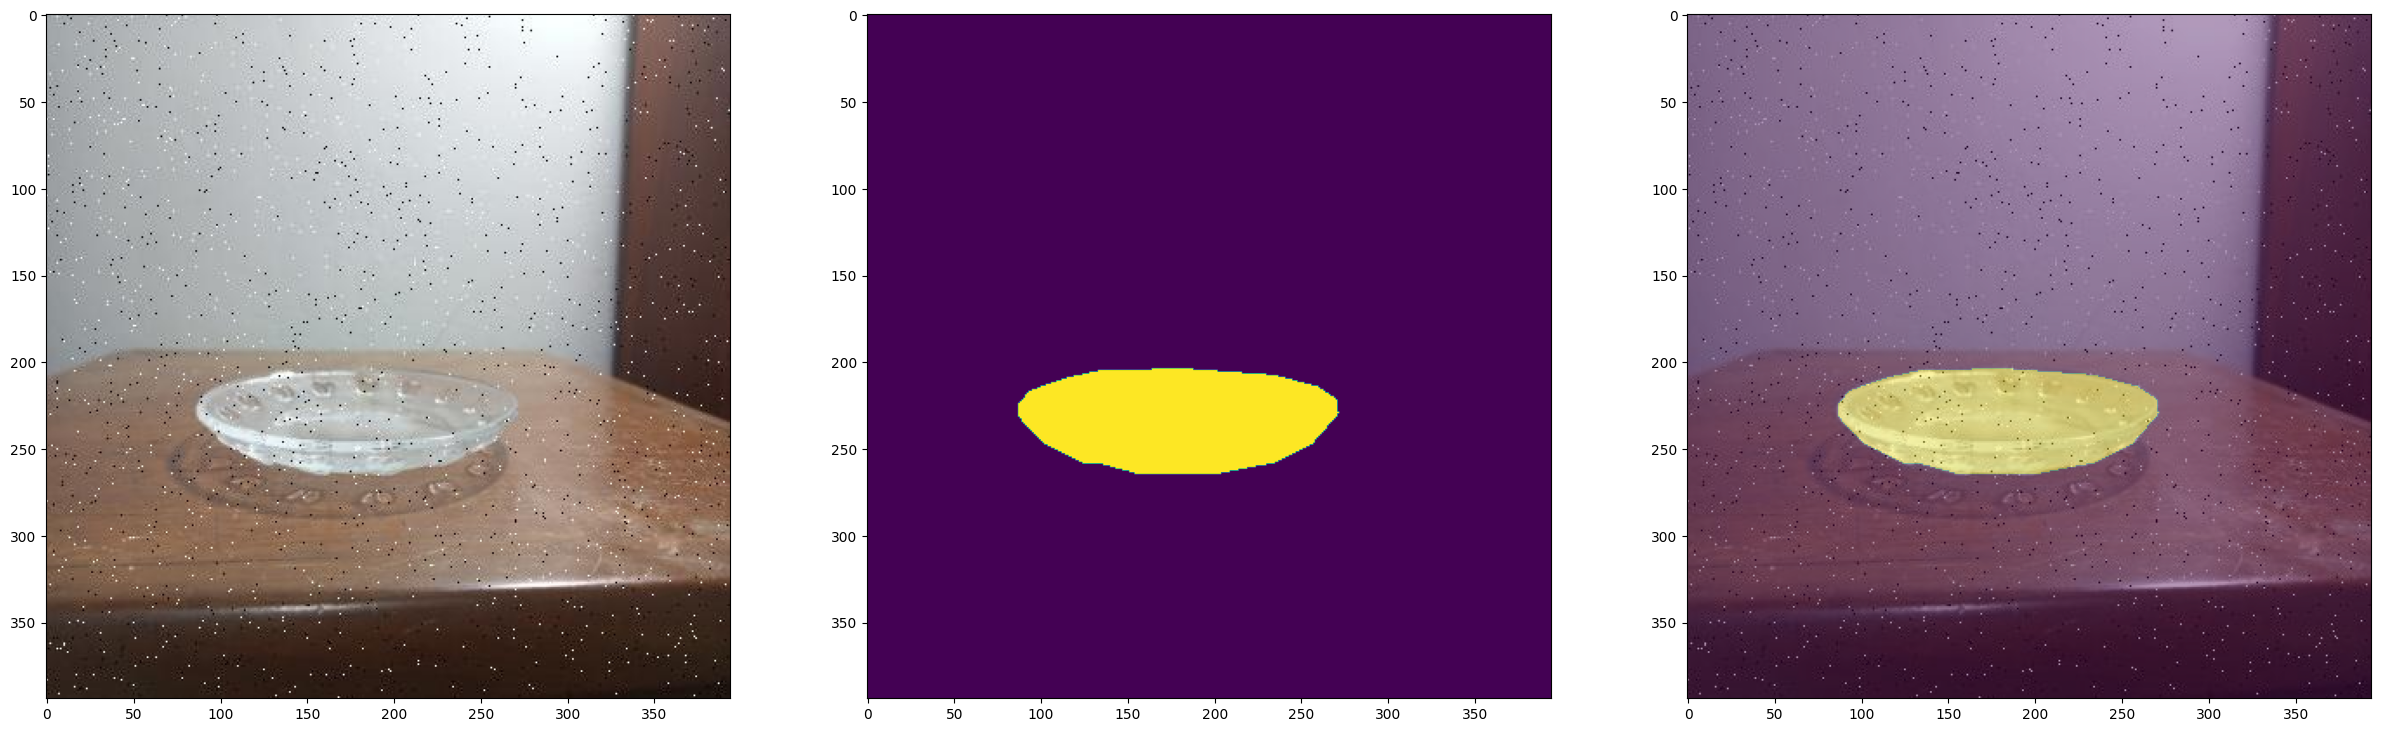

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
imagen = np.array(Image.open(img_train[3]))
print(imagen.dtype)
#img = imagen.astype(np.float32)
#print(imagen)
mask = mask_train[3]
print(mask.shape)
print(mask.shape)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))

ax1.imshow(imagen)
ax2.imshow(mask)
ax3.imshow(imagen)
ax3.imshow(mask, alpha=0.4)
plt.show()
#plt.imshow(mask)

In [ ]:
import albumentations as A
from skimage import io
from skimage import color
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, n_classes=3, transform=None):
        self.X = X
        self.y = y
        self.n_classes = n_classes
        self.transform = transform

    def __len__(self):
        return len(self.X)

    def __getitem__(self, ix):
        #image_load = Image.open(self.X[ix]).convert('RGB')
        img = io.imread(self.X[ix])
        #print(img)
        if img.shape[2] == 4:
            img = color.rgba2rgb(img)
        image = np.array(img) / 255
        img = image.astype(np.float32)

        mask = self.y[ix]
        img = torch.from_numpy(img).permute(2, 0, 1)
        mask = (np.arange(self.n_classes) == mask[..., None]).astype(np.float32)
        mask =torch.from_numpy(mask).permute(2, 0, 1)


        return img, mask

In [ ]:
dataset = {
    'train': Dataset(img_train, mask_train),
    'test': Dataset(img_test, mask_train)
}

len(dataset['train']), len(dataset['test'])

(780, 195)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=64, pin_memory=True)
}
imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([16, 3, 394, 394]), torch.Size([16, 3, 394, 394]))

## Entrenando con todo el dataset

Una vez hemos validado que nuestra red es capaz de hacer el fit de una imágen, podemos entrenar la red con todo el dataset.

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs=100, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=10)

test_loss 0.43587 test_iou 0.37337: 100%|██████████| 4/4 [00:03<00:00,  1.02it/s]



Epoch 1/10 loss 0.46008 iou 0.37701 test_loss 0.43587 test_iou 0.37337


test_loss 0.38527 test_iou 0.45361: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Epoch 2/10 loss 0.33567 iou 0.51919 test_loss 0.38527 test_iou 0.45361


test_loss 0.37057 test_iou 0.47281: 100%|██████████| 4/4 [00:04<00:00,  1.02s/it]



Epoch 3/10 loss 0.28428 iou 0.58528 test_loss 0.37057 test_iou 0.47281


test_loss 0.38698 test_iou 0.48248: 100%|██████████| 4/4 [00:03<00:00,  1.10it/s]



Epoch 4/10 loss 0.25303 iou 0.61372 test_loss 0.38698 test_iou 0.48248


test_loss 0.37018 test_iou 0.48057: 100%|██████████| 4/4 [00:03<00:00,  1.09it/s]



Epoch 5/10 loss 0.23350 iou 0.64809 test_loss 0.37018 test_iou 0.48057


test_loss 0.49011 test_iou 0.47128: 100%|██████████| 4/4 [00:03<00:00,  1.05it/s]



Epoch 6/10 loss 0.22023 iou 0.66170 test_loss 0.49011 test_iou 0.47128


test_loss 0.36079 test_iou 0.46968: 100%|██████████| 4/4 [00:03<00:00,  1.04it/s]



Epoch 7/10 loss 0.21170 iou 0.66720 test_loss 0.36079 test_iou 0.46968


test_loss 0.37209 test_iou 0.48450: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Epoch 8/10 loss 0.20129 iou 0.68516 test_loss 0.37209 test_iou 0.48450


test_loss 0.37003 test_iou 0.46265: 100%|██████████| 4/4 [00:03<00:00,  1.11it/s]



Epoch 9/10 loss 0.19429 iou 0.69504 test_loss 0.37003 test_iou 0.46265


test_loss 0.38774 test_iou 0.47101: 100%|██████████| 4/4 [00:04<00:00,  1.04s/it]


Epoch 10/10 loss 0.18469 iou 0.70674 test_loss 0.38774 test_iou 0.47101


In [ ]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/Chetpoint/modelo_394x394.pth')

In [ ]:
# Crear una instancia del modelo
modelo_cargado =UNet()
# Cargar los parámetros del modelo guardado en la instancia
#modelo_cargado.load_state_dict(torch.load('/content/modelo_UNetinception_394x394.pth'))
modelo_cargado.load_state_dict(torch.load('/content/drive/MyDrive/Chetpoint/modelo_394x394.pth'))

<All keys matched successfully>

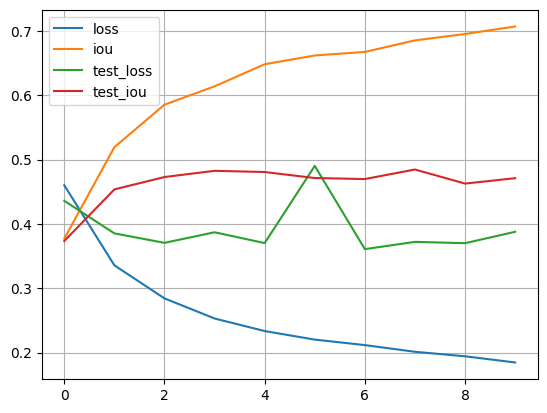

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

## Transfer Learning

Podemos mejorar nuestros resultados si en vez de entrenar nuestra `UNet` desde cero utilizamos una red ya entrenada gracias al `transfer learning`. Para ello usaremos `ResNet` como `backbone` en el `encoder` de la siguiente manera.

In [ ]:
import torchvision

In [ ]:
encoder = torchvision.models.resnet18(pretrained=True)
encoder

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
class out_conv(torch.nn.Module):
    def __init__(self, ci, co, coo):
        super(out_conv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv = conv3x3_bn(ci, co)
        self.final = torch.nn.Conv2d(co, coo, 1)

    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        x = self.conv(x1)
        x = self.final(x)
        return x

class UNetResnet(torch.nn.Module):
    def __init__(self, n_classes=3, in_ch=3):
        super().__init__()

        self.encoder = torchvision.models.resnet18(pretrained=True)
        if in_ch != 3:
          self.encoder.conv1 = torch.nn.Conv2d(in_ch, 64, kernel_size=7, stride=2, padding=3, bias=False)

        self.deconv1 = deconv(512,256)
        self.deconv2 = deconv(256,128)
        self.deconv3 = deconv(128,64)
        self.out = out_conv(64, 64, n_classes)

    def forward(self, x):
        x_in = torch.tensor(x.clone())
        x = self.encoder.relu(self.encoder.bn1(self.encoder.conv1(x)))
        x1 = self.encoder.layer1(x)
        x2 = self.encoder.layer2(x1)
        x3 = self.encoder.layer3(x2)
        x = self.encoder.layer4(x3)
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x, x_in)
        return x

In [ ]:
model = UNetResnet()
output = model(torch.randn((10,3,394,394)))
output.shape

<ipython-input-119-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


In [ ]:
model = UNetResnet()
hist = fit(model, dataloader, epochs=8)

  0%|          | 0/49 [00:00<?, ?it/s]<ipython-input-108-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())
test_loss 0.51454 test_iou 0.53446: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s]



Epoch 1/8 loss 0.42287 iou 0.76759 test_loss 0.51454 test_iou 0.53446


test_loss 0.47471 test_iou 0.53304: 100%|██████████| 7/7 [00:06<00:00,  1.12it/s]



Epoch 2/8 loss 0.25403 iou 0.91858 test_loss 0.47471 test_iou 0.53304


test_loss 0.47782 test_iou 0.53430: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]



Epoch 3/8 loss 0.19213 iou 0.93412 test_loss 0.47782 test_iou 0.53430


test_loss 0.47467 test_iou 0.53412: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]



Epoch 4/8 loss 0.14463 iou 0.95362 test_loss 0.47467 test_iou 0.53412


test_loss 0.52088 test_iou 0.53277: 100%|██████████| 7/7 [00:06<00:00,  1.14it/s]



Epoch 5/8 loss 0.10803 iou 0.97161 test_loss 0.52088 test_iou 0.53277


test_loss 0.52762 test_iou 0.53675: 100%|██████████| 7/7 [00:05<00:00,  1.17it/s]



Epoch 6/8 loss 0.08924 iou 0.96888 test_loss 0.52762 test_iou 0.53675


test_loss 0.53657 test_iou 0.53819: 100%|██████████| 7/7 [00:06<00:00,  1.11it/s]



Epoch 7/8 loss 0.07480 iou 0.96700 test_loss 0.53657 test_iou 0.53819


test_loss 0.50714 test_iou 0.53780: 100%|██████████| 7/7 [00:06<00:00,  1.13it/s]


Epoch 8/8 loss 0.05814 iou 0.97825 test_loss 0.50714 test_iou 0.53780


In [ ]:
import torch
# Supongamos que tienes un modelo llamado 'model' entrenado y deseas guardarlo
torch.save(model.state_dict(), '/content/drive/MyDrive/Chetpoint/modelo2_394x394.pth')


In [ ]:
# Crear una instancia del modelo
modelo_cargado =UNetResnet()
# Cargar los parámetros del modelo guardado en la instancia
#modelo_cargado.load_state_dict(torch.load('/content/modelo_UNetinception_394x394.pth'))
modelo_cargado.load_state_dict(torch.load('/content/drive/MyDrive/Chetpoint/modelo2_394x394.pth'))

<All keys matched successfully>

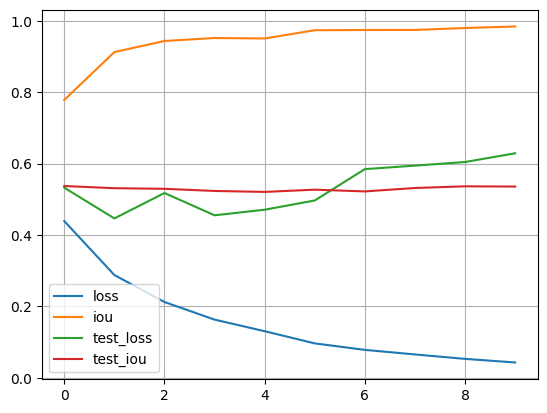

In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

En este caso observamos como la red converge más rápido, sin embargo no obtenemos una gran mejora de prestaciones ya que nuestro dataset es muy pequeño y la naturaleza de las imágenes es muy distinta a las utilizadas para entrenar `ResNet`. Podemos generar máscaras para imágenes del dataset de test de la siguiente manera.

<ipython-input-46-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


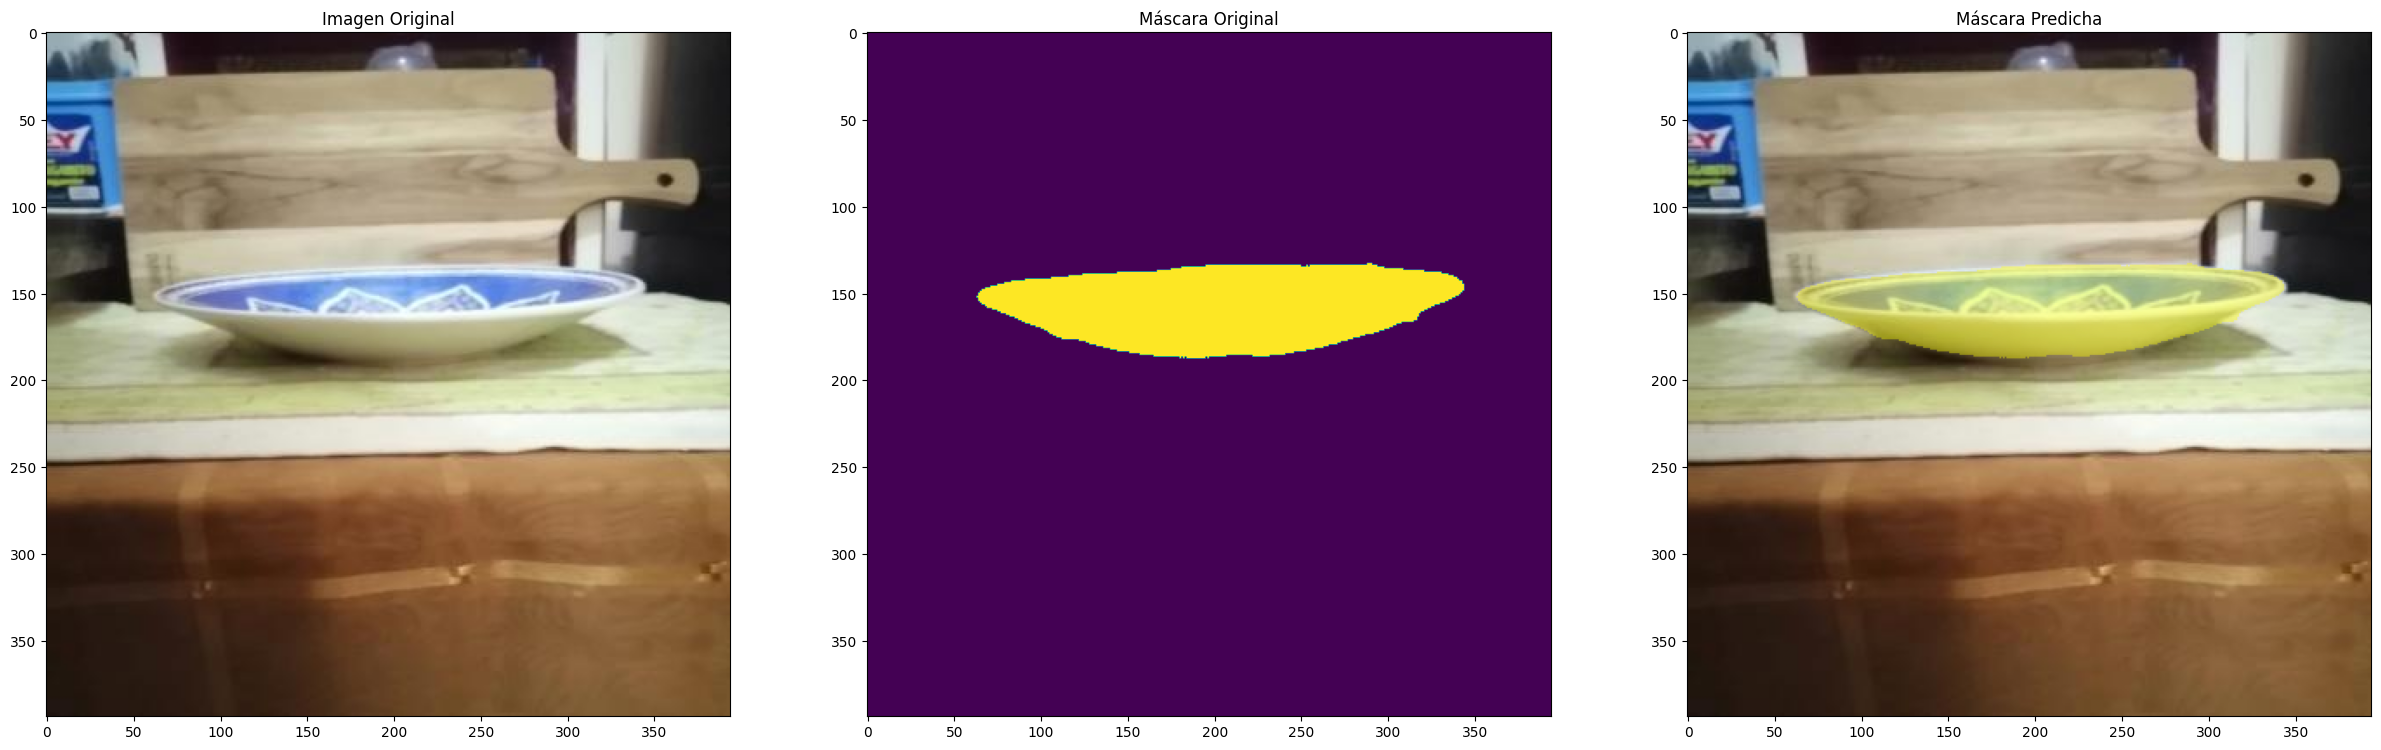

In [ ]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
device = torch.device('cuda')
modelo_cargado.eval()

with torch.no_grad():
    ix = random.randint(0, len(dataset['test']) - 1)
    img, mask = dataset['test'][ix]
    img = img.unsqueeze(0).to(device)
    mask = mask.to(device)
    modelo_cargado = modelo_cargado.to(device)
    img_resized = F.interpolate(img, size=(394, 394), mode='bilinear', align_corners=False)
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    # Redimensionar la máscara al tamaño de la imagen original (600x800)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convertir a NumPy array y transponer los ejes
# Configurar la transparencia de la máscara
colors = [(1, 1, 0, 0), (1, 1, 0, 0.4)]
cmap = LinearSegmentedColormap.from_list('CustomYellow', colors)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))
ax1.imshow(img)
ax1.set_title('Imagen Original')

ax2.imshow(mask_resized)
ax2.set_title('Máscara Original')

ax3.imshow(img)
#ax3.imshow(mask_resized, cmap='hot', alpha=0.4)
ax3.imshow(mask_resized, cmap=cmap)
ax3.set_title('Máscara Predicha')

plt.show()


In [ ]:
#def visualizar_prediccion(img, mask_predicha, mask_original):
def visualizar_prediccion(img, mask_predicha):
    # Configurar la transparencia y el color de la máscara
    colors = [(1, 1, 0, 0), (1, 1, 0, 0.4)]
    cmap = LinearSegmentedColormap.from_list('CustomYellow', colors)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30, 10))

    ax1.imshow(img)
    ax1.set_title('Imagen Original')

    ax2.imshow(mask_predicha)
    ax2.set_title('Máscara Predicha')

    ax3.imshow(img)
    ax3.imshow(mask_predicha, cmap=cmap)
    ax3.set_title('Máscara Con la Imagen Original')

    plt.show()

<ipython-input-46-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


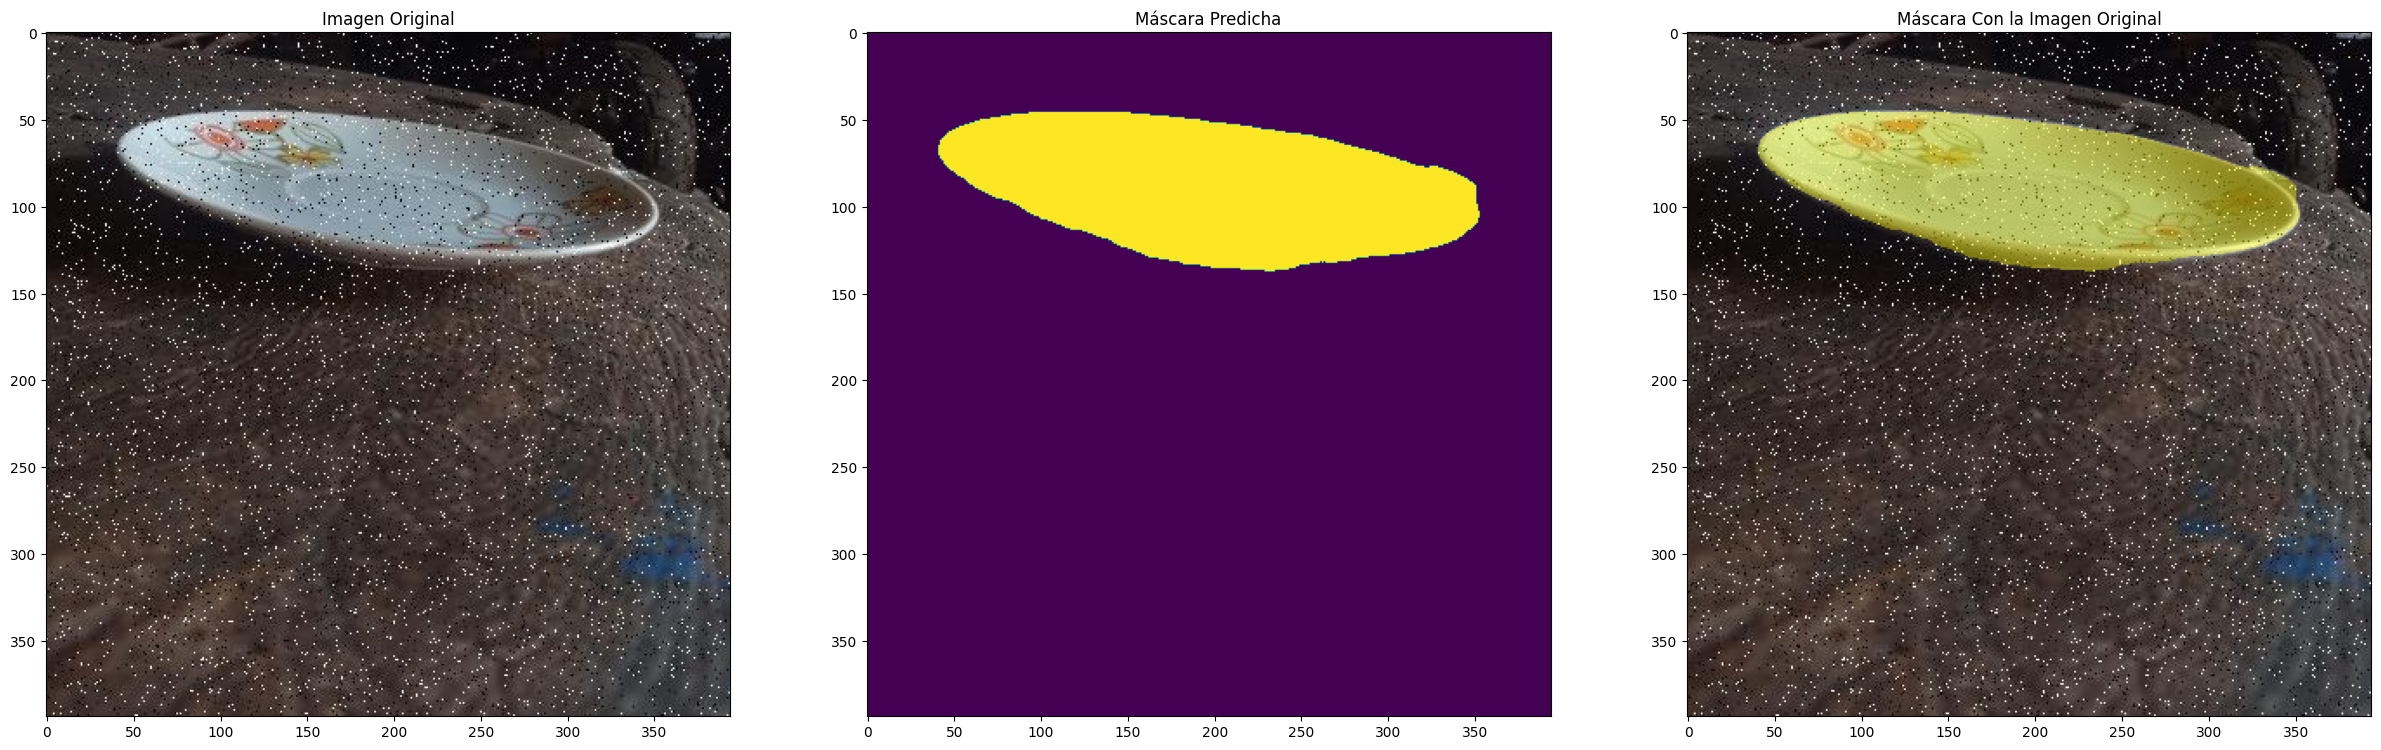

In [ ]:
import random
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

modelo_cargado.eval()

with torch.no_grad():
    ix = random.randint(0, len(dataset['test']) - 1)
    img, _ = dataset['test'][ix]
    img = img.unsqueeze(0).to(device)
    #mask = mask.to(device)
    modelo_cargado = modelo_cargado.to(device)
    img_resized = F.interpolate(img, size=(394, 394), mode='bilinear', align_corners=False)
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    # Redimensionar la máscara al tamaño de la imagen original (600x800)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img = img.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Convertir a NumPy array y transponer los ejes
# Configurar la transparencia de la máscara

#visualizar_prediccion(img, mask_resized, torch.argmax(mask, axis=0).cpu().numpy())
visualizar_prediccion(img, mask_resized)

In [ ]:
from PIL import Image
image_load_1 = Image.open('/content/drive/MyDrive/2parcial/Platos.v1i.coco-segmentation/test/platos_segundo_119_jpg.rf.9815ee24fad0cea3d258d56a8f3682fb.jpg').convert('RGB')
image_1 = np.array(image_load_1) / 255
img_1 = torch.from_numpy(image_1).permute(2, 0, 1).unsqueeze(0).to(device)

<ipython-input-46-654f1dbeffae>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_in = torch.tensor(x.clone())


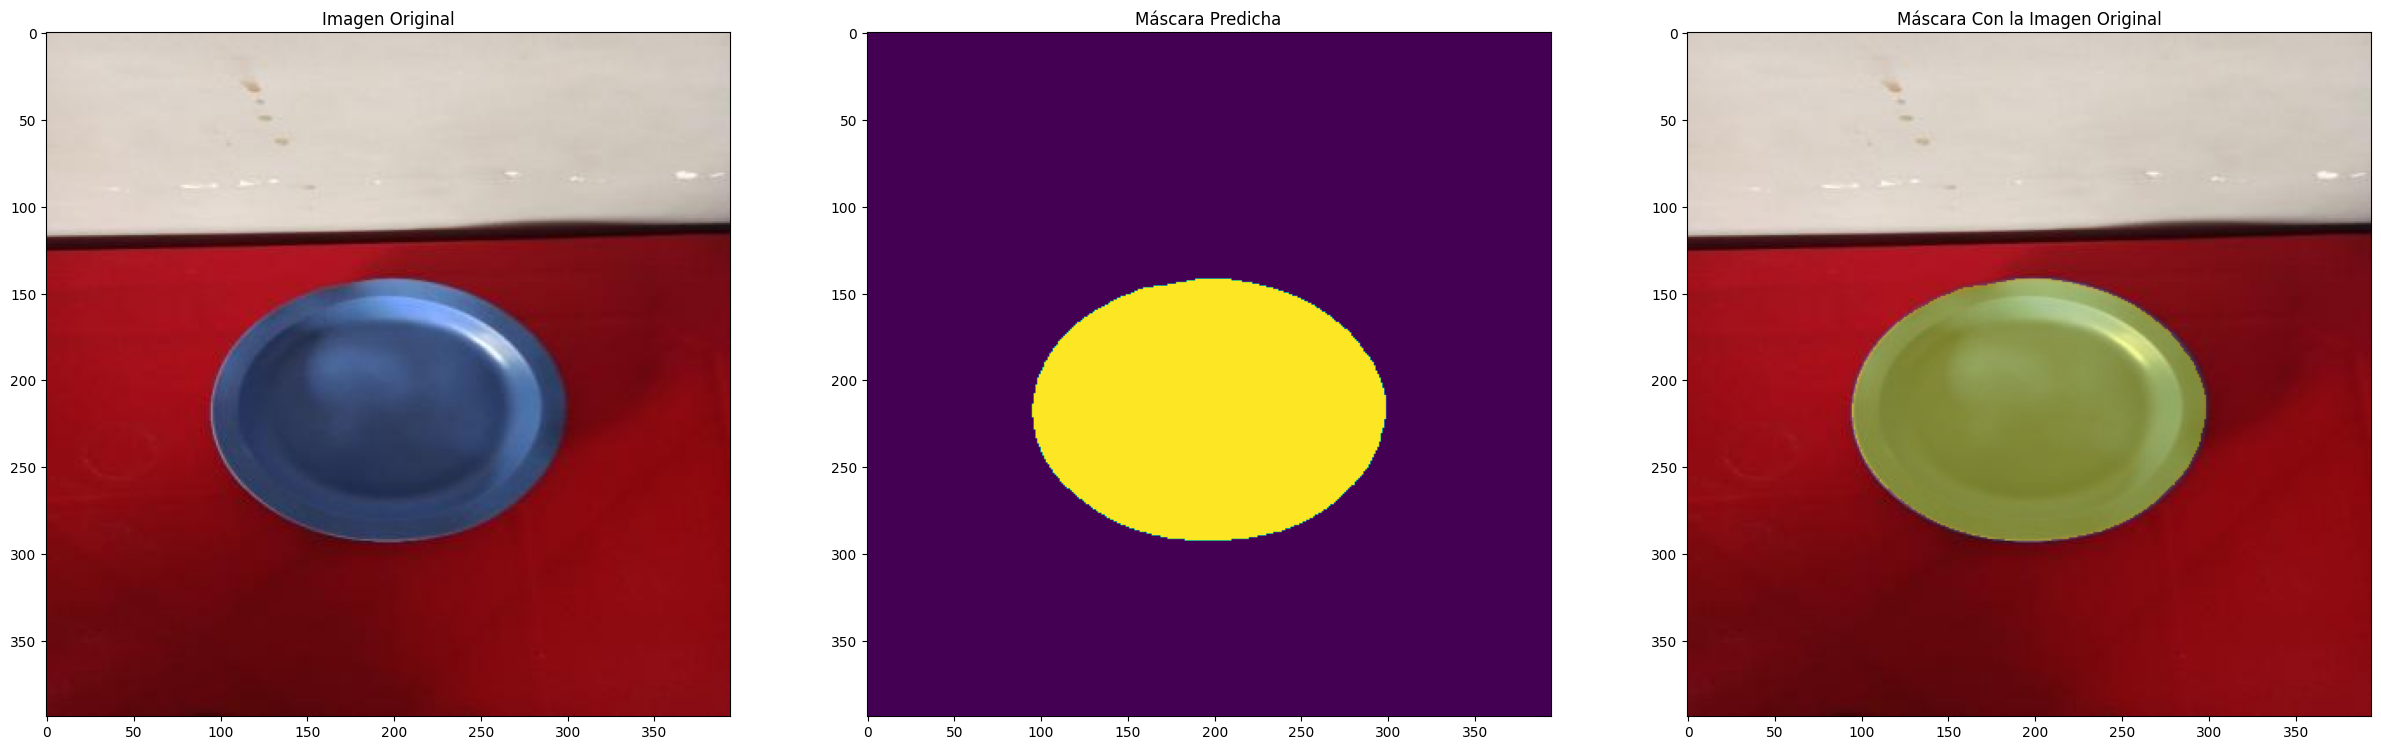

In [ ]:
with torch.no_grad():
    img_resized = F.interpolate(img_1, size=(394, 394), mode='bilinear', align_corners=False)
    img_resized = img_resized.float()  # Convertir a torch.cuda.FloatTensor
    output = modelo_cargado(img_resized)[0]
    pred_mask = torch.argmax(output, axis=0)
    mask_resized = F.interpolate(pred_mask.unsqueeze(0).unsqueeze(0).float(), size=(394, 394), mode='nearest').squeeze().cpu().numpy()
    img_1 = img_1.squeeze(0).cpu().numpy().transpose(1, 2, 0)
    # Redimensionar la imagen a 600x800
    img_1 = Image.fromarray((img_1 * 255).astype(np.uint8))
    img_1_resized = img_1.resize((394, 394))
    img_1_resized = np.array(img_1_resized) / 255

    visualizar_prediccion(img_1_resized, mask_resized)

## Resumen

En este post hemos visto como podemos implementar y entrenar una red convolucional para llevar a cabo la tarea de segmentación semántica. Esta tarea consiste en clasificar todos y cada uno de los píxeles en una imagen. De esta manera podemos producir máscaras de segmentación que nos permiten localizar los diferentes objetos presentes en una imagen de forma mucho más precisa que la que podemos conseguir con la detección de objetos. Este tipo de tarea puede utilizarse en aplicaciones como la conducción autónoma o sistemas de diagnóstico médico, como hemos visto en el ejemplo de este post.